# Cash Transaction Risk Features (AML)

## Overview
This notebook engineers AML risk features related to **cash-based transaction behavior**, focusing on pass-through activity, structuring patterns, abnormal timing, and cash channel misuse.

The features implemented here translate cash-related AML rules into **customer-level numerical signals** suitable for supervised and semi-supervised risk modeling.

---

## AML Signals / Rules Covered

### TX-CASH-11 — Cash → Wire Pass-Through
- **Entity**: Transaction → Customer
- **Window**: 3 days (evaluated within 30d context)
- **Aggregation**: Ratio
- **Columns Used**:
  - `cash_indicator`
  - `channel`
  - `amount_cad`
  - `transaction_datetime`
- **Description**: Cash deposits rapidly exiting via wire transfers

### TX-CASH-12 — Cash Structuring Pattern
- **Entity**: Transaction → Customer
- **Window**: 30 days
- **Aggregation**: Count / Max daily count
- **Columns Used**:
  - `amount_cad`
  - `transaction_datetime`
  - `branch_id` (proxy if unavailable)
- **Description**: Multiple sub-threshold cash deposits across locations

### TX-CASH-13 — Night-Time Cash Activity
- **Entity**: Transaction → Customer
- **Window**: 30 days
- **Aggregation**: Ratio
- **Columns Used**:
  - `cash_indicator`
  - `transaction_datetime`
  - `amount_cad`
- **Description**: High proportion of cash activity between 10 p.m. and 6 a.m.

### TX-CASH-14 — White-Label ATM Usage
- **Entity**: Transaction → Customer
- **Window**: 30 days
- **Aggregation**: Ratio
- **Columns Used**:
  - `merchant_category`
  - `channel`
  - `amount_cad`
- **Description**: Frequent use of non-bank or white-label ATMs

---

## Inputs
- `data/interim/master_transactions.csv`
- `data/interim/master_customers.csv`
- `data/raw/labels.csv` (partial supervision)

## Outputs
- Customer-level cash risk feature table
- Feature distribution plots by label
- Baseline supervised model metrics (ROC-AUC, PR-AUC)

## Goal
- Convert cash AML rules into interpretable features
- Validate signal behavior under severe class imbalance
- Prepare features for downstream risk scoring

## Notes
- Individual features are weak signals by design
- Emphasis is on **ranking**, not hard classification


In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path

# Change this if needed: should point to repo root
# If notebook launched from repo root:
# REPO_ROOT = Path.cwd()
# If notebook is inside /notebooks:
REPO_ROOT = Path.cwd().parents[0]

DATA_DIR = REPO_ROOT / "data"
cust_path   = DATA_DIR / "interim" / "master_customers.csv"
tx_path     = DATA_DIR / "interim" / "master_transactions.csv"
labels_path = DATA_DIR / "raw" / "labels.csv"

cust = pd.read_csv(cust_path)
tx   = pd.read_csv(tx_path)
labels = pd.read_csv(labels_path)

tx["transaction_datetime"] = pd.to_datetime(tx["transaction_datetime"], errors="coerce")

print("cust:", cust.shape, "tx:", tx.shape, "labels:", labels.shape)
print("tx columns:", tx.columns.tolist())


C:\Users\shany\AppData\Local\Temp\ipykernel_43124\1081112148.py:18: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  tx   = pd.read_csv(tx_path)


cust: (61410, 15) tx: (5903333, 15) labels: (1000, 2)
tx columns: ['transaction_id', 'customer_id', 'amount_cad', 'debit_credit', 'transaction_datetime', 'cash_indicator', 'country', 'province', 'city', 'channel', 'merchant_category', 'ecommerce_ind', 'is_debit', 'is_credit', '_source_table']


In [2]:
# minimal cleaning
tx = tx.copy()
tx = tx[tx["customer_id"].notna()].copy()
tx = tx[tx["transaction_datetime"].notna()].copy()

# ensure numeric
if "amount_cad" in tx.columns:
    tx["amount_cad"] = pd.to_numeric(tx["amount_cad"], errors="coerce").fillna(0.0)

# ensure is_credit/is_debit exist
if "is_credit" not in tx.columns or "is_debit" not in tx.columns:
    if "debit_credit" in tx.columns:
        dc = tx["debit_credit"].astype(str).str.upper().str.strip()
        tx["is_credit"] = dc.eq("C")
        tx["is_debit"]  = dc.eq("D")
    else:
        tx["is_credit"] = False
        tx["is_debit"]  = False

# ensure cash_indicator exists
if "cash_indicator" not in tx.columns:
    tx["cash_indicator"] = 0
tx["cash_indicator"] = pd.to_numeric(tx["cash_indicator"], errors="coerce").fillna(0).astype(int)

# normalize text cols
for c in ["channel", "merchant_category", "city", "province", "country"]:
    if c in tx.columns:
        tx[c] = tx[c].fillna("Unknown").astype(str).str.strip()

# location proxy for structuring (branch_id not available)
if "province" in tx.columns and "city" in tx.columns:
    tx["location_proxy"] = tx["province"].astype(str) + "|" + tx["city"].astype(str)
else:
    tx["location_proxy"] = "Unknown"

tx["date"] = tx["transaction_datetime"].dt.date
tx["hour"] = tx["transaction_datetime"].dt.hour

tx.head()


,transaction_id,customer_id,amount_cad,debit_credit,transaction_datetime,cash_indicator,country,province,city,channel,merchant_category,ecommerce_ind,is_debit,is_credit,_source_table,location_proxy,date,hour
0,ABM2411016110810,SYNID0104291988,300.0,D,2024-11-01 00:01:56,1,CA,BC,other,abm,Unknown,NaN,True,False,txns,BC|other,2024-11-01,0
1,ABM2411013831558,SYNID0103664053,400.0,C,2024-11-01 00:03:09,1,CA,NS,other,abm,Unknown,NaN,False,True,txns,NS|other,2024-11-01,0
2,ABM2411013725020,SYNID0106747172,400.0,D,2024-11-01 00:03:12,1,CA,BC,SURREY,abm,Unknown,NaN,True,False,txns,BC|SURREY,2024-11-01,0
3,ABM2411012851967,SYNID0106306354,320.0,D,2024-11-01 00:03:16,1,CA,BC,other,abm,Unknown,NaN,True,False,txns,BC|other,2024-11-01,0
4,ABM2411018908251,SYNID0105732044,1000.0,D,2024-11-01 00:04:19,1,CA,BC,SURREY,abm,Unknown,NaN,True,False,txns,BC|SURREY,2024-11-01,0


In [3]:
# minimal cleaning
tx = tx.copy()
tx = tx[tx["customer_id"].notna()].copy()
tx = tx[tx["transaction_datetime"].notna()].copy()

# ensure numeric
if "amount_cad" in tx.columns:
    tx["amount_cad"] = pd.to_numeric(tx["amount_cad"], errors="coerce").fillna(0.0)

# ensure is_credit/is_debit exist
if "is_credit" not in tx.columns or "is_debit" not in tx.columns:
    if "debit_credit" in tx.columns:
        dc = tx["debit_credit"].astype(str).str.upper().str.strip()
        tx["is_credit"] = dc.eq("C")
        tx["is_debit"]  = dc.eq("D")
    else:
        tx["is_credit"] = False
        tx["is_debit"]  = False

# ensure cash_indicator exists
if "cash_indicator" not in tx.columns:
    tx["cash_indicator"] = 0
tx["cash_indicator"] = pd.to_numeric(tx["cash_indicator"], errors="coerce").fillna(0).astype(int)

# normalize text cols
for c in ["channel", "merchant_category", "city", "province", "country"]:
    if c in tx.columns:
        tx[c] = tx[c].fillna("Unknown").astype(str).str.strip()

# location proxy for structuring (branch_id not available)
if "province" in tx.columns and "city" in tx.columns:
    tx["location_proxy"] = tx["province"].astype(str) + "|" + tx["city"].astype(str)
else:
    tx["location_proxy"] = "Unknown"

tx["date"] = tx["transaction_datetime"].dt.date
tx["hour"] = tx["transaction_datetime"].dt.hour

tx.head()


,transaction_id,customer_id,amount_cad,debit_credit,transaction_datetime,cash_indicator,country,province,city,channel,merchant_category,ecommerce_ind,is_debit,is_credit,_source_table,location_proxy,date,hour
0,ABM2411016110810,SYNID0104291988,300.0,D,2024-11-01 00:01:56,1,CA,BC,other,abm,Unknown,NaN,True,False,txns,BC|other,2024-11-01,0
1,ABM2411013831558,SYNID0103664053,400.0,C,2024-11-01 00:03:09,1,CA,NS,other,abm,Unknown,NaN,False,True,txns,NS|other,2024-11-01,0
2,ABM2411013725020,SYNID0106747172,400.0,D,2024-11-01 00:03:12,1,CA,BC,SURREY,abm,Unknown,NaN,True,False,txns,BC|SURREY,2024-11-01,0
3,ABM2411012851967,SYNID0106306354,320.0,D,2024-11-01 00:03:16,1,CA,BC,other,abm,Unknown,NaN,True,False,txns,BC|other,2024-11-01,0
4,ABM2411018908251,SYNID0105732044,1000.0,D,2024-11-01 00:04:19,1,CA,BC,SURREY,abm,Unknown,NaN,True,False,txns,BC|SURREY,2024-11-01,0


In [4]:
# For each customer, define end_date = their max transaction datetime
end_dt = tx.groupby("customer_id")["transaction_datetime"].max().rename("cust_end_dt")
tx = tx.merge(end_dt, on="customer_id", how="left")
tx["days_from_end"] = (tx["cust_end_dt"] - tx["transaction_datetime"]).dt.days

# last 30d window per customer
tx30 = tx[(tx["days_from_end"] >= 0) & (tx["days_from_end"] <= 30)].copy()

print("tx30:", tx30.shape, "unique customers:", tx30["customer_id"].nunique())


tx30: (1849928, 20) unique customers: 60213


In [5]:
# night definition: 22:00-06:00
is_night = (tx30["hour"] >= 22) | (tx30["hour"] < 6)

cash_mask = (tx30["cash_indicator"] == 1)
cash_amt = tx30["amount_cad"].where(cash_mask, 0.0)
night_cash_amt = tx30["amount_cad"].where(cash_mask & is_night, 0.0)

feat_night = tx30.groupby("customer_id").agg(
    cash_amt_sum_30d=("amount_cad", lambda s: float(cash_amt.loc[s.index].sum())),
    cash_txn_count_30d=("amount_cad", lambda s: int(cash_mask.loc[s.index].sum())),
    night_cash_amt_sum_30d=("amount_cad", lambda s: float(night_cash_amt.loc[s.index].sum())),
    night_cash_txn_count_30d=("amount_cad", lambda s: int((cash_mask & is_night).loc[s.index].sum())),
).reset_index()

feat_night["night_cash_ratio_30d"] = (
    feat_night["night_cash_amt_sum_30d"] / (feat_night["cash_amt_sum_30d"] + 1e-9)
)

feat_night.head()


,customer_id,cash_amt_sum_30d,cash_txn_count_30d,night_cash_amt_sum_30d,night_cash_txn_count_30d,night_cash_ratio_30d
0,SYNID0100000167,0.00,0,0.00,0,0.000000
1,SYNID0100000431,842.88,3,642.88,1,0.762718
2,SYNID0100000485,415.92,1,0.00,0,0.000000
3,SYNID0100000539,0.00,0,0.00,0,0.000000
4,SYNID0100000932,1083.49,1,0.00,0,0.000000


In [6]:
def cash_to_wire_passthrough_ratio(tx30_customer: pd.DataFrame, horizon_days=3) -> float:
    df = tx30_customer.sort_values("transaction_datetime").copy()

    cash_in = df[(df["cash_indicator"] == 1) & (df["is_credit"])]
    wire_out = df[(df["channel"].str.lower() == "wire") & (df["is_debit"])]

    cash_in_amt = cash_in["amount_cad"].sum()
    if cash_in_amt <= 0 or cash_in.empty or wire_out.empty:
        return 0.0

    wire_times = wire_out["transaction_datetime"].to_numpy(dtype="datetime64[ns]")
    wire_amts  = wire_out["amount_cad"].to_numpy()

    # prefix sum for wire amounts for fast range sums
    pref = np.cumsum(wire_amts)

    def range_sum(i0, i1):
        if i1 <= i0:
            return 0.0
        return float(pref[i1-1] - (pref[i0-1] if i0 > 0 else 0.0))

    total_wire_after_cash = 0.0
    for t0 in cash_in["transaction_datetime"].to_numpy(dtype="datetime64[ns]"):
        t1 = t0 + np.timedelta64(horizon_days, "D")
        left  = np.searchsorted(wire_times, t0, side="left")
        right = np.searchsorted(wire_times, t1, side="right")
        total_wire_after_cash += range_sum(left, right)

    return float(total_wire_after_cash / (cash_in_amt + 1e-9))


# compute per customer
grp = tx30.groupby("customer_id", sort=False)
passthrough = grp.apply(lambda g: cash_to_wire_passthrough_ratio(g, horizon_days=3))
passthrough = passthrough.rename("cash_to_wire_ratio_3d_30d").reset_index()

passthrough.head()


C:\Users\shany\AppData\Local\Temp\ipykernel_43124\4230654353.py:34: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  passthrough = grp.apply(lambda g: cash_to_wire_passthrough_ratio(g, horizon_days=3))


,customer_id,cash_to_wire_ratio_3d_30d
0,SYNID0200996134,0.0
1,SYNID0100292788,0.0
2,SYNID0200150511,0.0
3,SYNID0104323223,0.0
4,SYNID0200691500,0.0


In [7]:
THRESH = 10000.0
BAND_LO = 8000.0
BAND_HI = 10000.0

# define "cash deposit" proxy
cash_deposit = (tx30["cash_indicator"] == 1) & (tx30["is_credit"])
near_thresh = cash_deposit & (tx30["amount_cad"] >= BAND_LO) & (tx30["amount_cad"] < BAND_HI)

tx30["is_cash_deposit"] = cash_deposit.astype(int)
tx30["is_near_thresh_cash_dep"] = near_thresh.astype(int)

# daily counts for bursts
daily = tx30[near_thresh].groupby(["customer_id", "date"]).agg(
    near_thresh_cash_dep_count=("transaction_id", "count"),
    near_thresh_cash_dep_amt=("amount_cad", "sum"),
).reset_index()

max_daily = daily.groupby("customer_id").agg(
    cash_max_daily_near_thresh_count_30d=("near_thresh_cash_dep_count", "max"),
    cash_days_with_2plus_near_thresh_30d=("near_thresh_cash_dep_count", lambda s: int((s >= 2).sum())),
).reset_index()

# location spread proxy
loc = tx30[near_thresh].groupby("customer_id").agg(
    cash_near_thresh_count_30d=("transaction_id", "count"),
    cash_near_thresh_amt_sum_30d=("amount_cad", "sum"),
    cash_near_thresh_distinct_locations_30d=("location_proxy", "nunique"),
).reset_index()

feat_struct = loc.merge(max_daily, on="customer_id", how="left").fillna(0)

feat_struct.head()


,customer_id,cash_near_thresh_count_30d,cash_near_thresh_amt_sum_30d,cash_near_thresh_distinct_locations_30d,cash_max_daily_near_thresh_count_30d,cash_days_with_2plus_near_thresh_30d
0,SYNID0101236707,1,8981.81,1,1,0
1,SYNID0102508549,1,8900.00,1,1,0
2,SYNID0108116399,1,8613.45,1,1,0
3,SYNID0200753047,1,9998.07,1,1,0


In [8]:
# proxy keywords for "white-label" contexts; adjust later after seeing merchant_category values
WL_KEYWORDS = [
    "hotel", "motel", "inn",
    "casino", "lottery",
    "convenience", "c-store", "corner store",
    "gas", "fuel",
    "atm", "abm", "kiosk"
]

mc = tx30["merchant_category"].str.lower()
is_white_label_context = mc.apply(lambda s: any(k in s for k in WL_KEYWORDS))

# consider ABM channel as ATM-like
is_abm = tx30["channel"].str.lower().eq("abm")

# define "ABM usage in white-label context"
wl_abm = is_abm & is_white_label_context

feat_wl = tx30.groupby("customer_id").agg(
    abm_txn_count_30d=("transaction_id", lambda s: int(is_abm.loc[s.index].sum())),
    wl_abm_txn_count_30d=("transaction_id", lambda s: int(wl_abm.loc[s.index].sum())),
).reset_index()

feat_wl["white_label_abm_ratio_30d"] = feat_wl["wl_abm_txn_count_30d"] / (feat_wl["abm_txn_count_30d"] + 1e-9)

feat_wl.head()


,customer_id,abm_txn_count_30d,wl_abm_txn_count_30d,white_label_abm_ratio_30d
0,SYNID0100000167,0,0,0.0
1,SYNID0100000431,3,0,0.0
2,SYNID0100000485,2,0,0.0
3,SYNID0100000539,0,0,0.0
4,SYNID0100000932,1,0,0.0


In [9]:
features_cash = (
    feat_night
    .merge(passthrough, on="customer_id", how="outer")
    .merge(feat_struct, on="customer_id", how="outer")
    .merge(feat_wl, on="customer_id", how="outer")
)

# fill missing with 0 for numeric feature columns
for c in features_cash.columns:
    if c != "customer_id":
        features_cash[c] = pd.to_numeric(features_cash[c], errors="coerce").fillna(0.0)

features_cash = features_cash.sort_values("customer_id").reset_index(drop=True)

out_path = DATA_DIR / "processed" / "features_cash_30d.csv"
out_path.parent.mkdir(parents=True, exist_ok=True)
features_cash.to_csv(out_path, index=False)

print("Saved:", out_path)
features_cash.head()


Saved: c:\Users\shany\Documents\GitHub\aml-project\data\processed\features_cash_30d.csv


,customer_id,cash_amt_sum_30d,cash_txn_count_30d,night_cash_amt_sum_30d,night_cash_txn_count_30d,night_cash_ratio_30d,cash_to_wire_ratio_3d_30d,cash_near_thresh_count_30d,cash_near_thresh_amt_sum_30d,cash_near_thresh_distinct_locations_30d,cash_max_daily_near_thresh_count_30d,cash_days_with_2plus_near_thresh_30d,abm_txn_count_30d,wl_abm_txn_count_30d,white_label_abm_ratio_30d
0,SYNID0100000167,0.00,0,0.00,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0
1,SYNID0100000431,842.88,3,642.88,1,0.762718,0.0,0.0,0.0,0.0,0.0,0.0,3,0,0.0
2,SYNID0100000485,415.92,1,0.00,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2,0,0.0
3,SYNID0100000539,0.00,0,0.00,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0
4,SYNID0100000932,1083.49,1,0.00,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.0


In [10]:
# figure out label column name
print("labels columns:", labels.columns.tolist())

# try common names
label_col = None
for cand in ["label", "is_suspicious", "suspicious", "y", "target"]:
    if cand in labels.columns:
        label_col = cand
        break

if label_col is None:
    # if labels.csv is exactly two cols: customer_id + label
    non_id_cols = [c for c in labels.columns if c != "customer_id"]
    if len(non_id_cols) == 1:
        label_col = non_id_cols[0]

print("Using label_col:", label_col)

dfL = features_cash.merge(labels[["customer_id", label_col]], on="customer_id", how="inner")
dfL[label_col] = pd.to_numeric(dfL[label_col], errors="coerce").fillna(0).astype(int)

print("Labeled rows:", dfL.shape, "positive rate:", dfL[label_col].mean())
dfL.head()


labels columns: ['customer_id', 'label']
Using label_col: label
Labeled rows: (973, 16) positive rate: 0.010277492291880781


,customer_id,cash_amt_sum_30d,cash_txn_count_30d,night_cash_amt_sum_30d,night_cash_txn_count_30d,night_cash_ratio_30d,cash_to_wire_ratio_3d_30d,cash_near_thresh_count_30d,cash_near_thresh_amt_sum_30d,cash_near_thresh_distinct_locations_30d,cash_max_daily_near_thresh_count_30d,cash_days_with_2plus_near_thresh_30d,abm_txn_count_30d,wl_abm_txn_count_30d,white_label_abm_ratio_30d,label
0,SYNID0100000485,415.92,1,0.00,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2,0,0.0,0
1,SYNID0100021236,0.00,0,0.00,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0
2,SYNID0100059315,0.00,0,0.00,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0
3,SYNID0100060562,0.00,0,0.00,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0
4,SYNID0100075150,271.50,3,41.47,1,0.152744,0.0,0.0,0.0,0.0,0.0,0.0,3,0,0.0,0


In [11]:
from sklearn.metrics import roc_auc_score

y = dfL[label_col].values
feature_cols = [c for c in dfL.columns if c not in ["customer_id", label_col]]

uni = []
for c in feature_cols:
    x = dfL[c].values
    # constant columns have no AUC
    if np.nanstd(x) < 1e-12:
        continue
    try:
        auc = roc_auc_score(y, x)
    except ValueError:
        continue
    uni.append((c, auc, np.nanmean(x[y==1]) if y.sum() else np.nan, np.nanmean(x[y==0])))

uni = sorted(uni, key=lambda t: abs(t[1] - 0.5), reverse=True)
pd.DataFrame(uni, columns=["feature", "roc_auc", "mean_pos", "mean_neg"]).head(15)


,feature,roc_auc,mean_pos,mean_neg
0,cash_amt_sum_30d,0.542004,662.102000,164.756355
1,cash_txn_count_30d,0.536604,1.300000,0.580478
2,night_cash_amt_sum_30d,0.532139,26.681000,8.924465
3,night_cash_ratio_30d,0.531308,0.047072,0.019069
4,night_cash_txn_count_30d,0.531049,0.100000,0.042575
5,abm_txn_count_30d,0.525026,1.300000,0.672897


Top univariate features: ['cash_amt_sum_30d', 'cash_txn_count_30d', 'night_cash_amt_sum_30d']


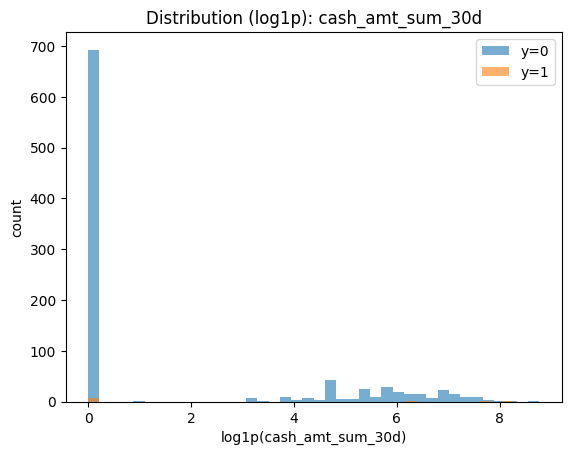

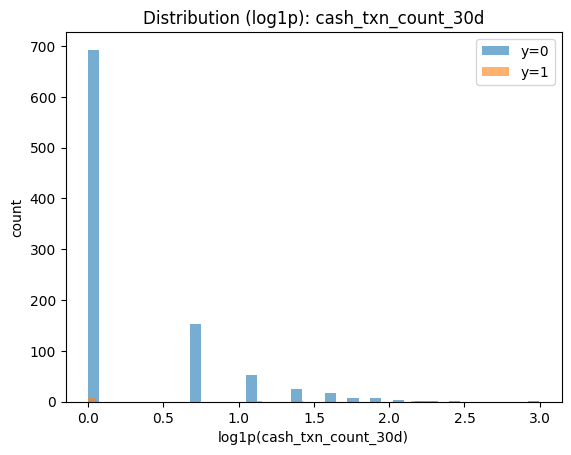

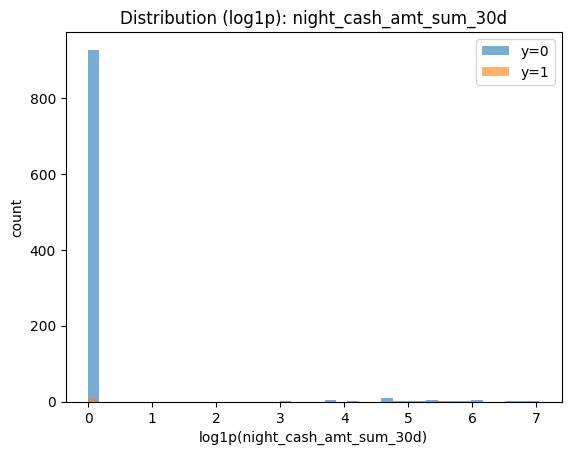

In [12]:
import matplotlib.pyplot as plt

top_feats = [r[0] for r in uni[:3]]
print("Top univariate features:", top_feats)

for f in top_feats:
    plt.figure()
    x0 = dfL.loc[dfL[label_col]==0, f].values
    x1 = dfL.loc[dfL[label_col]==1, f].values
    # log1p to reduce heavy tail dominance
    plt.hist(np.log1p(x0), bins=40, alpha=0.6, label="y=0")
    plt.hist(np.log1p(x1), bins=40, alpha=0.6, label="y=1")
    plt.title(f"Distribution (log1p): {f}")
    plt.xlabel(f"log1p({f})")
    plt.ylabel("count")
    plt.legend()
    plt.show()


LogReg AP (PR-AUC): 0.010308077572651564
LogReg ROC-AUC: 0.33195020746887965


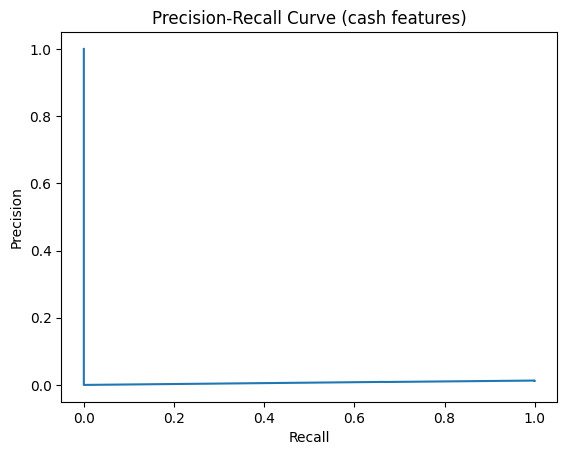

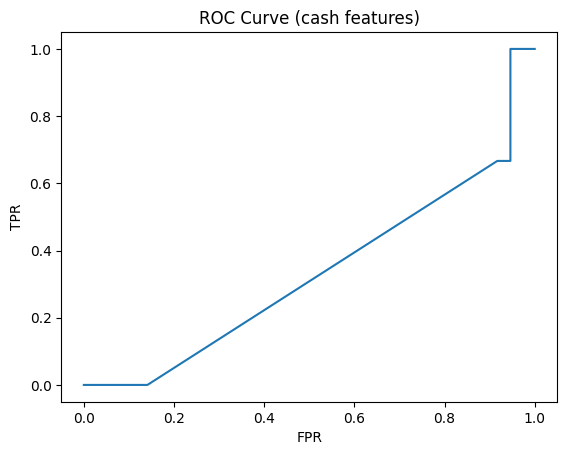

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve, roc_curve

X = dfL[feature_cols].copy()
y = dfL[label_col].copy()

# fill any weird NAs
X = X.replace([np.inf, -np.inf], np.nan).fillna(0.0)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

lr = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("model", LogisticRegression(max_iter=500, class_weight="balanced"))
])

lr.fit(X_train, y_train)
proba = lr.predict_proba(X_test)[:, 1]

ap = average_precision_score(y_test, proba)
auc = roc_auc_score(y_test, proba)

print("LogReg AP (PR-AUC):", ap)
print("LogReg ROC-AUC:", auc)

# PR curve
prec, rec, _ = precision_recall_curve(y_test, proba)
plt.figure()
plt.plot(rec, prec)
plt.title("Precision-Recall Curve (cash features)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, proba)
plt.figure()
plt.plot(fpr, tpr)
plt.title("ROC Curve (cash features)")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()


In [14]:
def recall_at_k(y_true, scores, k):
    idx = np.argsort(scores)[::-1][:k]
    return float(y_true.iloc[idx].sum() / (y_true.sum() + 1e-9))

for k in [10, 25, 50, 100, 200]:
    print("recall@%-3d =" % k, recall_at_k(y_test.reset_index(drop=True), pd.Series(proba), k))


recall@10  = 0.0
recall@25  = 0.0
recall@50  = 0.0
recall@100 = 0.0
recall@200 = 0.6666666664444444


In [15]:
# score everyone with cash features (even unlabeled) using the LR fitted on labeled set
X_all = features_cash[feature_cols].copy()
X_all = X_all.replace([np.inf, -np.inf], np.nan).fillna(0.0)

risk_cash = lr.predict_proba(X_all)[:, 1]

cash_scores = pd.DataFrame({
    "customer_id": features_cash["customer_id"],
    "risk_score_cash_supervised": risk_cash
}).sort_values("risk_score_cash_supervised", ascending=False)

cash_out = DATA_DIR / "processed" / "cash_risk_scores.csv"
cash_scores.to_csv(cash_out, index=False)
print("Saved:", cash_out)

cash_scores.head(20)


Saved: c:\Users\shany\Documents\GitHub\aml-project\data\processed\cash_risk_scores.csv


,customer_id,risk_score_cash_supervised
26166,SYNID0104966031,1.0
32047,SYNID0106068054,1.0
51638,SYNID0109807796,1.0
1438,SYNID0100276809,1.0
28691,SYNID0105434699,1.0
43431,SYNID0108214643,1.0
34838,SYNID0106606476,1.0
54744,SYNID0200284137,1.0
43505,SYNID0108229005,1.0
40478,SYNID0107656340,1.0


## Conclusion Checklist (Cash Features)

This notebook produced customer-level cash features aligned with AML rules. To judge whether they are usable:

1) **Do any cash features show univariate lift?**  
   - Check the univariate AUC table.  
   - If AUC is ~0.5 for all, cash-only signals are weak in this dataset (not unusual).

2) **Do the distributions separate at all?**  
   - Use log1p histograms.  
   - If y=1 has heavier right tail, the feature is usable for ranking.

3) **Does a baseline model improve PR-AUC vs random?**  
   - With ~1% positive rate, PR-AUC is expected to be low.  
   - Even small improvements can still be useful for top-k review.

4) **Operational metric:** recall@k  
   - If recall@100 is meaningfully > baseline, this is valuable.

Next step after this notebook:
- Build **wire** and **EMT** notebooks similarly, then merge all features and train a stronger baseline.
